In [1]:
# %pip install -U "langchain>=0.3.7,<0.4" "langchain-core>=0.3.15,<0.4" langchain-openai python-dotenv


### Step 0: Prerequisites & Setup

- Python 3.9+
- a virtual environment
- OpenAI API Key in .env as `OpenAI_API_KEY`
- Sanity check for having access to OpenAI API and be able to run a simple chat completion via LangChain 

In [22]:
import os
from dotenv import load_dotenv

# Load environment variables from .env file
if os.path.exists(".env"):
    load_dotenv()
    print("Environment variables loaded from .env file.")


# Access the API keys
api_key = os.getenv("OPENAI_API_KEY")

if api_key:
    print("OpenAI API Key loaded successfully!")

else:
    print("API Key not found. Please check your .env file.")
    

Environment variables loaded from .env file.
OpenAI API Key loaded successfully!


In [3]:
from langchain_openai import ChatOpenAI
from langchain_core.messages import SystemMessage, HumanMessage

# Intialize chat model via LangChain
chat = ChatOpenAI(model="gpt-4o", temperature=0.8)

messages = [
    SystemMessage(content="You're a helpful assistant"),
    HumanMessage(content="What are the hot research topics in 2025? Return your answer in 5 sentences and in bullet points."),
]

print(chat.invoke(messages).content)

I'm unable to predict specific future events or topics, including the exact hot research topics of 2025. However, based on current trends and areas of rapid development, I can suggest some areas that are likely to remain significant:

- **Artificial Intelligence and Machine Learning**: Continued advancements in AI, focusing on ethical AI, general AI capabilities, and AI applications across industries such as healthcare, finance, and autonomous systems.
  
- **Quantum Computing**: Research in quantum algorithms, error correction, and practical applications of quantum computing in solving complex problems that are intractable for classical computers.
  
- **Sustainability and Climate Tech**: Innovations in renewable energy, carbon capture technologies, sustainable agriculture, and circular economy models to address climate change and environmental challenges.
  
- **Biotechnology and Genomics**: Advances in CRISPR and gene editing technologies, personalized medicine, and synthetic biolog

### Step 1: Create a basic agent

The goal is to implement one or two simple tools and build an initial workflow to verify that everything functions correctly before adding more tools and complexity.

In [4]:
# tool 1: execute_sql_query
import sqlite3
from langchain.tools import tool

@tool
def execute_sql_query(sql_query: str, db_path: str) -> str:
    """
    Executes a SQL query on a local SQLite database.
    Args:
        sql_query (str): SQL query to execute.
        db_path (str): Path to the SQLite database file.
    Returns:
        str: Results formatted as Markdown table or error message.
    """
    try:
        connect = sqlite3.connect(db_path)
        cursor = connect.cursor()
        cursor.execute(sql_query)

        # Handle SELECT queries
        if sql_query.strip().upper().startswith("SELECT"):
            rows = cursor.fetchall()
            if not rows:
                return "No results found."

            # Get column names
            column_names = [description[0] for description in cursor.description]
            # Format as Markdown table
            markdown_table = "  " + " | ".join(column_names) + " |\n"
            markdown_table += "|" + "|".join(["---"] * len(column_names)) + "|\n"
            for row in rows:
                markdown_table += "| " + " | ".join(str(cell) for cell in row) + " |\n"
            return markdown_table

        # Handle INSERT/UPDATE/DELETE
        else:
            connect.commit()
            return f"Query executed successfully. {cursor.rowcount} rows affected."

    except sqlite3.Error as e:
        return f"SQL Error: {str(e)}"
    finally:
        connect.close()

In [5]:
# tool 2: get_db_schema
import json

@tool
def get_db_schema(db_path: str = "../data") -> str:
    """
    Retrieves simplified schema information for all SQLite databases in JSON format.
    Args:
        db_path (str): Path to directory containing SQLite database files. Defaults to "../data".
    Returns:
        str: JSON string containing simplified schema information.
    """
    result = {
        "databases": [],
        "error": None
    }

    # Find all database files
    db_files = []
    for file in os.listdir(db_path):
        if file.endswith(('.db', '.sqlite', '.sqlite3')):
            db_files.append({
                "path": os.path.join(db_path, file),
                "name": os.path.basename(file)
            })

    if not db_files:
        result["error"] = "No SQLite database files found in the specified directory."
        return json.dumps(result, indent=2)

    for db_file in db_files:
        try:
            conn = sqlite3.connect(db_file["path"])
            cursor = conn.cursor()

            database = {
                "name": db_file["name"],
                "path": db_file["path"],
                "tables": []
            }

            # Get all tables
            cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
            tables = [table[0] for table in cursor.fetchall()]

            for table in tables:
                table_info = {
                    "name": table,
                    "columns": []    
                }

                # Get column information
                cursor.execute(f"PRAGMA table_info({table})")
                columns = cursor.fetchall()
                for col in columns:
                    table_info["columns"].append({
                        "name": col[1],
                        "type": col[2]
                    })

                database["tables"].append(table_info)

            result["databases"].append(database)
            conn.close()

        except Exception as e:
            result["databases"].append({
                "name": db_file["name"],
                "error": str(e)
            })

    return json.dumps(result, indent=2)


In [6]:
# main.py
from langgraph.graph import StateGraph, START, END
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, AIMessage, ToolMessage
from typing import TypedDict, Annotated, Sequence
from langgraph.graph.message import add_messages

# 1. Define agent state
class AgentState(TypedDict):
    messages: Annotated[Sequence[HumanMessage | AIMessage | ToolMessage], add_messages]

# 2. Initialize LLM
llm = ChatOpenAI(model="gpt-4", temperature=0, api_key=api_key)
tools = [get_db_schema, execute_sql_query]
llm_with_tools = llm.bind_tools(tools)

# 3. Define nodes
def call_model(state: AgentState):
    """Call LLM with tools"""
    response = llm_with_tools.invoke(state["messages"])
    return {"messages": [response]}

def call_tool(state: AgentState):
    """Execute tools"""
    outputs = []
    for tool_call in state["messages"][-1].tool_calls:
        if tool_call["name"] == "get_db_schema":
            result = get_db_schema.invoke({"db_path": "../data"})
        else:  # execute_sql_query
            result = execute_sql_query.invoke(tool_call["args"])

        outputs.append(ToolMessage(
            content=result,
            name=tool_call["name"],
            tool_call_id=tool_call["id"]
        ))
    return {"messages": outputs}

def should_continue(state: AgentState) -> str:
    """Decide whether to continue"""
    last_message = state["messages"][-1]
    if hasattr(last_message, "tool_calls") and last_message.tool_calls:
        return "tool"
    return "end"

# 4. Build graph
workflow = StateGraph(AgentState)
workflow.add_node("model", call_model)
workflow.add_node("tool", call_tool)
workflow.add_edge(START, "model")
workflow.add_conditional_edges(
    "model",
    should_continue,
    {"tool": "tool", "end": END}
)
workflow.add_edge("tool", "model")
app = workflow.compile()

In [7]:
# 5. Simple test function
def test(Message):
    system_prompt = """You are a SQL assistant with these tools:
    1. get_db_schema: Get database structure
    2. execute_sql_query: Run SQL queries
    Always get the schema first before running queries."""

    # Test 1: Get schema
    print("=== Test 1: Get Schema ===")
    response = app.invoke({
        "messages": [
            HumanMessage(content=system_prompt + "\nWhat tables exist in the database?")
        ]
    })
    print(response["messages"][-1].content)

    # Test 2: Simple query
    print("\n=== Test 2: Simple Query ===")
    response = app.invoke({
        "messages": [
            HumanMessage(content=system_prompt + "\n" + Message)
        ]
    })
    print(response["messages"][-1].content)


test("Show me 10 movies from 2021 from netflix.db")

=== Test 1: Get Schema ===
There are three databases each with one table:

1. Database: amazon_prime.db
   - Table: shows
     - Columns: show_id, type, title, director, cast, country, date_added, release_year, rating, duration, listed_in, description, added_at

2. Database: disney_plus.db
   - Table: shows
     - Columns: show_id, type, title, director, cast, country, date_added, release_year, rating, duration, listed_in, description, added_at

3. Database: netflix.db
   - Table: shows
     - Columns: show_id, type, title, director, cast, country, date_added, release_year, rating, duration, listed_in, description, added_at

=== Test 2: Simple Query ===
Here are 10 movies from 2021 available on Netflix:

1. My Little Pony: A New Generation
2. The Starling
3. Je Suis Karl
4. Confessions of an Invisible Girl
5. Intrusion
6. Go! Go! Cory Carson: Chrissy Takes the Wheel
7. Ankahi Kahaniya
8. The Father Who Moves Mountains
9. The Stronghold
10. My Heroes Were Cowboys


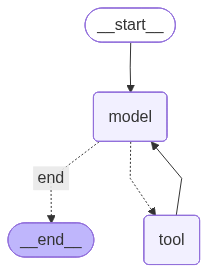

In [8]:
from IPython.display import Image, display

def display_graph(graph: any):
    try:
        display(Image(graph.get_graph().draw_mermaid_png()))
    except Exception:
        # This requires some extra dependencies and is optional
        pass
    
def print_stream(stream):
    for s in stream:
        message = s["messages"][-1]
        if isinstance(message, tuple):
            print(message)
        else:
            message.pretty_print()

display_graph(app)

In [9]:
user_query = "Show me 5 movies from 2020"
system_prompt = """You are a SQL assistant with these tools:
    1. get_db_schema: Get database structure
    2. execute_sql_query: Run SQL queries
    Always get the schema first before running queries."""
inputs = {"messages": [("user", user_query)], "system_prompt": system_prompt}
print_stream(app.stream(inputs, stream_mode="values"))

================================ Human Message =================================

Show me 5 movies from 2020
================================== Ai Message ==================================

To provide you with the information, I need to know the database schema. Let's fetch it first.
Tool Calls:
  get_db_schema (call_BXQ1108NZcSI3aMzTHgvBvWY)
 Call ID: call_BXQ1108NZcSI3aMzTHgvBvWY
  Args:
================================= Tool Message =================================
Name: get_db_schema

{
  "databases": [
    {
      "name": "amazon_prime.db",
      "path": "../data\\amazon_prime.db",
      "tables": [
        {
          "name": "shows",
          "columns": [
            {
              "name": "show_id",
              "type": "TEXT"
            },
            {
              "name": "type",
              "type": "TEXT"
            },
            {
              "name": "title",
              "type": "TEXT"
            },
            {
              "name": "director",
          

### Step 2: Add more tools and improve the workflow
Extend the agent with additional tools and enhance the workflow structure to support more complex interactions, better modularity, and smoother execution.

In [10]:
OMDb_base_url = "http://www.omdbapi.com/?i=tt3896198&apikey="
OMDb_API_KEY = os.getenv("OMDb_API_Key")
full_OMDb_url = OMDb_base_url + OMDb_API_KEY
OMDb_API_Parameters = {
"byIdOrTitle": {
"i": {
"required": False,
"validOptions": "",
"default": "",
"description": "A valid IMDb ID (e.g. tt1285016)"
},
"t": {
"required": False,
"validOptions": "",
"default": "",
"description": "Movie title to search for"
},
"type": {
"required": False,
"validOptions": ["movie", "series", "episode"],
"default": "",
"description": "Type of result to return"
},
"y": {
"required": False,
"validOptions": "",
"default": "",
"description": "Year of release"
},
"plot": {
"required": False,
"validOptions": ["short", "full"],
"default": "short",
"description": "Return short or full plot"
},
"r": {
"required": False,
"validOptions": ["json", "xml"],
"default": "json",
"description": "The data type to return"
},
"callback": {
"required": False,
"validOptions": "",
"default": "",
"description": "JSONP callback name"
},
"v": {
"required": False,
"validOptions": "",
"default": "1",
"description": "API version (reserved for future use)"
},
"note": "At least one of 'i' or 't' is required."
},
"bySearch": {
"s": {
"required": True,
"validOptions": "",
"default": "",
"description": "Movie title to search for"
},
"type": {
"required": False,
"validOptions": ["movie", "series", "episode"],
"default": "",
"description": "Type of result to return"
},
"y": {
"required": False,
"validOptions": "",
"default": "",
"description": "Year of release"
},
"r": {
"required": False,
"validOptions": ["json", "xml"],
"default": "json",
"description": "The data type to return"
},
"page": {
"required": False,
"validOptions": "1-100",
"default": "1",
"description": "Page number to return"
},
"callback": {
"required": False,
"validOptions": "",
"default": "",
"description": "JSONP callback name"
},
"v": {
"required": False,
"validOptions": "",
"default": "1",
"description": "API version (reserved for future use)"
}
}
}

print("Full OMDb URL: ", full_OMDb_url)

Full OMDb URL:  http://www.omdbapi.com/?i=tt3896198&apikey=8871ab87


In [11]:
import requests

OMDb_base_url = "http://www.omdbapi.com/"
OMDb_API_KEY = os.getenv("OMDb_API_Key")

def query_omdb(by="id", **kwargs):
    """
    by: "id" pour recherche par IMDb ID ou titre
    "search" pour recherche par mot-clé
    kwargs: paramètres de l'API
    """
    params = {"apikey": OMDb_API_KEY}

    if by == "id":
        if "i" in kwargs:
            params["i"] = kwargs["i"]
        elif "t" in kwargs:
            params["t"] = kwargs["t"]
        else:
            raise ValueError("Il faut fournir au moins 'i' ou 't' pour la recherche par ID/titre")
    elif by == "search":
        if "s" not in kwargs:
                raise ValueError("Le paramètre 's' est obligatoire pour la recherche générale")
        params["s"] = kwargs["s"]
        params["page"] = kwargs.get("page", "1")
    else:
        raise ValueError("Paramètre 'by' invalide : 'id' ou 'search'")

    # Paramètres optionnels
    for opt in ["type", "y", "plot", "r", "callback", "v"]:
        if opt in kwargs and kwargs[opt]:
                params[opt] = kwargs[opt]

    response = requests.get(OMDb_base_url, params=params)
    response.raise_for_status()
    return response.json()

# Exemple d'utilisation
film = query_omdb(by="id", i="tt3896198", plot="full")
search_results = query_omdb(by="search", s="Inception", type="movie")
print(film)
print(search_results)


{'Title': 'Guardians of the Galaxy Vol. 2', 'Year': '2017', 'Rated': 'PG-13', 'Released': '05 May 2017', 'Runtime': '136 min', 'Genre': 'Action, Adventure, Comedy', 'Director': 'James Gunn', 'Writer': 'James Gunn, Dan Abnett, Andy Lanning', 'Actors': 'Chris Pratt, Zoe Saldaña, Dave Bautista', 'Plot': "After saving Xandar from Ronan's wrath, the Guardians are now recognized as heroes. Now the team must help their leader Star Lord (Chris Pratt) uncover the truth behind his true heritage. Along the way, old foes turn to allies and betrayal is blooming. And the Guardians find that they are up against a devastating new menace who is out to rule the galaxy.", 'Language': 'English', 'Country': 'United States', 'Awards': 'Nominated for 1 Oscar. 15 wins & 60 nominations total', 'Poster': 'https://m.media-amazon.com/images/M/MV5BNWE5MGI3MDctMmU5Ni00YzI2LWEzMTQtZGIyZDA5MzQzNDBhXkEyXkFqcGc@._V1_SX300.jpg', 'Ratings': [{'Source': 'Internet Movie Database', 'Value': '7.6/10'}, {'Source': 'Rotten Tom

In [12]:
# Tool 3: OMDb API Query

import os
from typing import Optional
import requests
from langchain.tools import tool

OMDb_base_url = "http://www.omdbapi.com/"
OMDb_API_KEY = os.getenv("OMDb_API_Key")

@tool
def api_omdb_query(by: str = "search", i: Optional[str] = None, t: Optional[str] = None, 
                   s: Optional[str] = None, type: Optional[str] = "movie", y: Optional[str] = None, plot: str = "full", 
                   r: str = "json", page: str = "1", callback: Optional[str] = None, v: str = "1"
               ) -> dict:
    """
    Query the OMDb API by IMDb ID/title or search term.

    Args:
        by (str): "id" for IMDb ID/title, "search" for keyword search.
        i (str): IMDb ID (e.g., tt3896198)
        t (str): Movie title
        s (str): Search keyword (required for by='search')
        type (str): "movie", "series", "episode"
        y (str): Year of release
        plot (str): "short" or "full"
        r (str): Response format "json" or "xml"
        page (str): Page number for search results
        callback (str): JSONP callback name
        v (str): API version (reserved)

    Returns:
        dict: API response as JSON or error message
    """
    try:
        api_params = {"apikey": OMDb_API_KEY}

        if by == "id":
                if i:
                        api_params["i"] = i
                elif t:
                        api_params["t"] = t
                else:
                        return {"error": "Il faut fournir 'i' ou 't' pour by='id'"}

        elif by == "search":
                if not s:
                        return {"error": "Le paramètre 's' est obligatoire pour by='search'"}
                api_params["s"] = s
                api_params["page"] = page

        else:
                return {"error": "Paramètre 'by' invalide : 'id' ou 'search'"}

        for opt_name, opt_value in [("type", type), ("y", y), ("plot", plot), ("r", r), ("callback", callback), ("v", v)]:
                if opt_value:
                        api_params[opt_name] = opt_value

        response = requests.get(OMDb_base_url, params=api_params)
        response.raise_for_status()
        return response.json()

    except requests.RequestException as e:
        return {"error": f"Erreur lors de l'appel API: {str(e)}"}


In [13]:
# 1. Define agent state
class AgentState(TypedDict):
    messages: Annotated[Sequence[HumanMessage | AIMessage | ToolMessage], add_messages]

# 2. Initialize LLM
llm = ChatOpenAI(model="gpt-4", temperature=0)
tools = [get_db_schema, execute_sql_query, api_omdb_query]
llm_with_tools = llm.bind_tools(tools)

# 3. Define nodes
def call_model(state: AgentState):
    """Call LLM with tools"""
    response = llm_with_tools.invoke(state["messages"])
    return {"messages": [response]}

def call_tool(state: AgentState):
    """Execute tools"""
    outputs = []
    for tool_call in state["messages"][-1].tool_calls:
        if tool_call["name"] == "get_db_schema":
            result = get_db_schema.invoke({"db_path": "../data"})
        else:  # execute_sql_query
            result = execute_sql_query.invoke(tool_call["args"])

        outputs.append(ToolMessage(
            content=result,
            name=tool_call["name"],
            tool_call_id=tool_call["id"]
        ))
    return {"messages": outputs}

def should_continue(state: AgentState) -> str:
    """Decide whether to continue"""
    last_message = state["messages"][-1]
    if hasattr(last_message, "tool_calls") and last_message.tool_calls:
        return "tool"
    return "end"

# 4. Build graph
workflow = StateGraph(AgentState)
workflow.add_node("model", call_model)
workflow.add_node("tool", call_tool)
workflow.add_edge(START, "model")
workflow.add_conditional_edges(
    "model",
    should_continue,
    {"tool": "tool", "end": END}
)
workflow.add_edge("tool", "model")
app = workflow.compile()

In [14]:
user_query = "Show me a movie and his poster from 2020, with the rating above 8"
system_prompt = """You are a SQL assistant with these tools:
    1. get_db_schema: Get database structure
    2. execute_sql_query: Run SQL queries
    3. api_omdb_query: Query movie information from OMDb API
    Always get the schema first before running queries."""
inputs = {"messages": [("user", user_query)], "system_prompt": system_prompt}
print_stream(app.stream(inputs, stream_mode="values"))

================================ Human Message =================================

Show me a movie and his poster from 2020, with the rating above 8
================================== Ai Message ==================================
Tool Calls:
  api_omdb_query (call_WuiNPFFv4isgKKiOUAKNvUUG)
 Call ID: call_WuiNPFFv4isgKKiOUAKNvUUG
  Args:
    by: search
    s: 2020
    type: movie
    y: 2020


ValidationError: 2 validation errors for execute_sql_query
sql_query
  Field required [type=missing, input_value={'by': 'search', 's': '20...': 'movie', 'y': '2020'}, input_type=dict]
    For further information visit https://errors.pydantic.dev/2.12/v/missing
db_path
  Field required [type=missing, input_value={'by': 'search', 's': '20...': 'movie', 'y': '2020'}, input_type=dict]
    For further information visit https://errors.pydantic.dev/2.12/v/missing